In [7]:
import matplotlib.pyplot as plt
import nltk
import pandas as pd
import re
from unicodedata import normalize
from collections import Counter
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, recall_score, precision_score, matthews_corrcoef, make_scorer
from tpot import TPOTClassifier
from copy import copy
from sklearn.metrics import PrecisionRecallDisplay
from tpot.export_utils import set_param_recursive
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import make_pipeline, make_union
from sklearn.naive_bayes import MultinomialNB

[nltk_data] Downloading package stopwords to C:\Users\Eliel
[nltk_data]     Leandro\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Eliel
[nltk_data]     Leandro\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Leitura dos dados

In [8]:
train = pd.read_csv('../data/Data_Train.csv')
test = pd.read_csv('../data/Data_Test.csv')

 Visualizando o dataframe do conjunto de treino

In [9]:
train.head()

,ID,Message,SPAM
0,615317,Linda msg!,True
1,855344,To fazendo batida de kwui com coco,True
2,1007222,Esse dinheiro só vai sair para quem está com o...,True
3,811063,Isso msm Irmã.. nao lembrava dos nomes kkk,True
4,913944,Ai xara eu sujiro esse,True


Visualizando o dataframe do conjunto de teste

In [10]:
test.head()

,ID,Message
0,405268,Bom dia!!! Divulga ae!!!🎼🎵🎶🎧📢\nVamos!!!🍻
1,810119,to bem\nfznd o que de bom?\ntbm nada
2,439979,E ai cambada\nTrankilo?\nTrankilo cmo eskilo\n...
3,928898,Ouçam a conversa gravada no carro do Cristiano...
4,500412,"Nem, mete o piru no Pirra! Ele quer te dar"


### Análise Exploratória dos Dados (EDA)

#### Gerando as estatísicas descritivas do dataframe train

In [11]:
train.drop('ID', axis=1, inplace=True)

In [12]:
train.describe()

,Message,SPAM
count,1773,1773
unique,1758,2
top,---\n---\nEnviado através do WhatsApp,True
freq,5,932


#### Análise de quantas mensagens são spam ou não

Criando um novo dataframe com as quantidades de mensagens

In [13]:
num_spam=pd.DataFrame(train.groupby('SPAM').count())

Renomeação de coluna

In [14]:
num_spam=num_spam.rename(columns={'Message':'Number_Messages'})

 Gráfico

<Figure size 864x576 with 0 Axes>

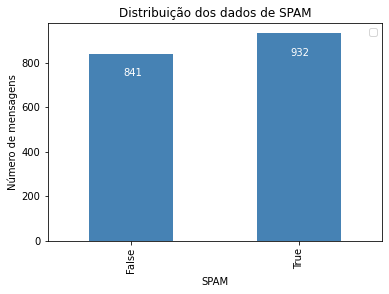

In [15]:
plt.figure(figsize=(12,8))
num_spam.plot(kind='bar', color='steelblue')
for index, value in enumerate(num_spam['Number_Messages']):
  plt.annotate(value, xy=(index-0.05, value-100), color='white')
plt.legend('')
plt.title('Distribuição dos dados de SPAM')
plt.ylabel('Número de mensagens')
plt.show()

 De acordo com a gráfico acima não encontramos um desequilíbrio entre as classes

#### Análise do comprimento das mensagens

Calcular o tamanho das mensagens e cria uma nova coluna no dataframe train com o tamanho encontrado

In [16]:
train['Message_len'] = train['Message'].apply(len)
train.head()

,Message,SPAM,Message_len
0,Linda msg!,True,10
1,To fazendo batida de kwui com coco,True,34
2,Esse dinheiro só vai sair para quem está com o...,True,137
3,Isso msm Irmã.. nao lembrava dos nomes kkk,True,42
4,Ai xara eu sujiro esse,True,22


In [17]:
train[train['SPAM'] == False]['Message_len'].describe()

count     841.000000
mean      192.977408
std       399.582327
min         7.000000
25%        55.000000
50%       108.000000
75%       198.000000
max      7204.000000
Name: Message_len, dtype: float64

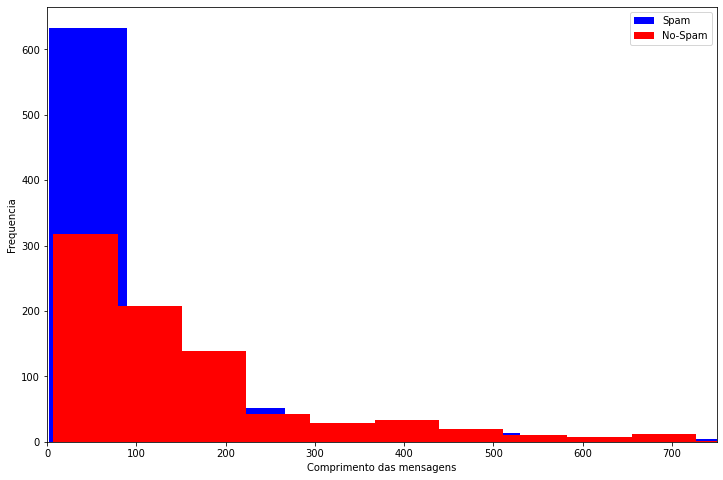

In [18]:
plt.figure(figsize=(12,8))
train[train['SPAM'] == True].Message_len.plot(kind='hist', bins=100, color = 'blue', label ='Spam')
train[train['SPAM'] == False].Message_len.plot(kind='hist', bins=100, color= 'red', label = 'No-Spam')
plt.xlabel('Comprimento das mensagens')
plt.xlim([0,750])
plt.ylabel('Frequencia')
plt.legend()
plt.show()

Podemos verificar que o comprimento da mensagem de spam e não-spam tende a ter o mesmo comprimento

### Pré-Processo do texto

Guardando as stopwords em português

In [19]:
nltk.download('stopwords')
from nltk.corpus import stopwords
nltk.download('punkt')
nltk_stopwords = stopwords.words('portuguese')

Função para remover todas as stopwords das mensagens

In [20]:
def remove_stopwords(texto):
  text_new = []
  tokens = nltk.word_tokenize(texto)
  for token in tokens:
    if len(token) > 2 and token not in nltk_stopwords:
      text_new.append(token)
  output = ' '.join(text_new)
  return output

 Romovendo todos os caracteres especiais das mensagens

In [21]:
def normalize_text(text):
  text = re.sub(r'[-.;?!:,"()\']','', text)
  text = remove_stopwords(text)
  text= normalize('NFKD', text).encode('ASCII', 'ignore').decode('ASCII')
  text = str(text).lower()
  return text

Criando uma nova coluna no dataframe train para as mensagens normalizadas

In [22]:
train['Normalize_text']=train['Message'].apply(normalize_text)
train.head()

,Message,SPAM,Message_len,Normalize_text
0,Linda msg!,True,10,linda msg
1,To fazendo batida de kwui com coco,True,34,fazendo batida kwui coco
2,Esse dinheiro só vai sair para quem está com o...,True,137,esse dinheiro vai sair nome lista esse dinheir...
3,Isso msm Irmã.. nao lembrava dos nomes kkk,True,42,isso msm irma nao lembrava nomes kkk
4,Ai xara eu sujiro esse,True,22,xara sujiro


#### Visualização dos Tokens

Visualizar quantas vezes cada palavra aparece

In [23]:
def count_tokens(df, boolean):

  words = train[df['SPAM']==boolean]['Normalize_text'].apply(lambda x: [text.lower() for text in x.split()])
  count = Counter()
  for msg in words:
    count.update(msg)
  return count

##### Contagem para SPAM

In [24]:
words_count_spam = count_tokens(train, True)

##### Contagem das palavras em ordem decrescente

In [25]:
words_count_spam.most_common()

[('nao', 175),
 ('pra', 124),
 ('dia', 110),
 ('vai', 103),
 ('bom', 96),
 ('todos', 78),
 ('agora', 67),
 ('quot', 67),
 ('kkk', 65),
 ('kkkk', 65),
 ('boa', 64),
 ('vou', 58),
 ('vcs', 55),
 ('deus', 54),
 ('grupo', 52),
 ('fazer', 52),
 ('tudo', 51),
 ('mensagem', 50),
 ('que', 49),
 ('rss', 47),
 ('pessoas', 46),
 ('aqui', 43),
 ('x2f', 43),
 ('hoje', 42),
 ('pode', 42),
 ('vamos', 41),
 ('cara', 41),
 ('kkkkk', 41),
 ('fala', 40),
 ('quero', 40),
 ('nome', 39),
 ('mas', 39),
 ('bem', 38),
 ('favor', 37),
 ('rio', 37),
 ('sei', 37),
 ('por', 36),
 ('ver', 35),
 ('nada', 34),
 ('porra', 34),
 ('voce', 32),
 ('gente', 32),
 ('assim', 32),
 ('sim', 31),
 ('alguem', 30),
 ('quem', 30),
 ('amigos', 30),
 ('dinheiro', 29),
 ('kkkkkk', 29),
 ('meu', 29),
 ('noite', 29),
 ('vida', 29),
 ('anos', 28),
 ('sempre', 28),
 ('melhor', 28),
 ('ainda', 28),
 ('foto', 27),
 ('ela', 27),
 ('casa', 27),
 ('fica', 26),
 ('tempo', 26),
 ('galera', 26),
 ('tem', 26),
 ('brasil', 26),
 ('geral', 25),
 ('

 Contagem para Não-Spam

In [26]:
words_count_nospam = count_tokens(train, False)

 Contagem das palavras em ordem decrescente

In [27]:
words_count_nospam.most_common()

[('rua', 201),
 ('dia', 171),
 ('bom', 115),
 ('boa', 88),
 ('pra', 87),
 ('rio', 81),
 ('nao', 77),
 ('bairro', 77),
 ('aqui', 74),
 ('agora', 71),
 ('favor', 69),
 ('ajuda', 68),
 ('sao', 68),
 ('nome', 67),
 ('todos', 65),
 ('agua', 65),
 ('onibus', 57),
 ('nada', 57),
 ('video', 56),
 ('tarde', 56),
 ('hoje', 53),
 ('dias', 51),
 ('fazer', 50),
 ('pois', 49),
 ('prefeitura', 48),
 ('vcs', 47),
 ('grande', 46),
 ('hospital', 45),
 ('frente', 45),
 ('gostaria', 43),
 ('por', 42),
 ('nova', 41),
 ('noite', 41),
 ('anos', 40),
 ('meu', 40),
 ('desde', 38),
 ('casa', 37),
 ('volta', 36),
 ('empresa', 35),
 ('local', 35),
 ('goncalo', 34),
 ('iguacu', 33),
 ('manha', 33),
 ('campo', 32),
 ('estrada', 31),
 ('vai', 31),
 ('carro', 31),
 ('joao', 31),
 ('ainda', 30),
 ('assim', 30),
 ('vamos', 30),
 ('criancas', 30),
 ('onde', 30),
 ('praca', 29),
 ('moradores', 29),
 ('brt', 29),
 ('santa', 29),
 ('reportagem', 28),
 ('estacao', 28),
 ('policia', 28),
 ('fica', 28),
 ('barra', 28),
 ('des

#### Visualização das principais palavras

Juntando todas a mensagens de spam em um só texto

In [28]:
def merge_text(df,text):
  total_text = ' '.join([text for text in df.loc[df['SPAM'] == text, 'Normalize_text']])
  return total_text

In [29]:
total_spam_text = merge_text(train, True)
total_spam_text

'linda msg fazendo batida kwui coco esse dinheiro vai sair nome lista esse dinheiro vai sair nome lista isso msm irma nao lembrava nomes kkk xara sujiro muito bom add vcs bom dia sou nova friburgo nao perco programa acordo vcs sua cachorrera responde vai esperar tony ent nao assisto filme kkkk kkkk alguem baseado aee alguem baseado aee neh neh kakak kakak keredo nem vsf mlq manda lixo aki tbm vsf lixo vsf apaguei travo aki lixao louvado deus fala mano artur servico hoje presidio bangu hoje dia banho sol vou compra piscina pode cre vamos marca bebe gelo paola taty gordinho solteiros rsrs bangu policia melicianos batman parana presidio federal gordinho falou solteiro tbm verdadi solteiro premeiro paola taty agora gordinho fogo formaro quente apampa sim gordinho vai mora lori agora pode cre sumiro grupo koe artur vou fazer contagem detentos aqui valeu apareceu artur apareceu koe tati sabendo nova solteira pista precisamos fotos teta tefinha pra add face manda buceta entao faca grupo feliz

##### Juntando todas a mensagens de não-spam em um só texto

In [30]:
total_nospam_text = merge_text(train, False)
total_nospam_text

'barata andando supermercados extra pilares nao primeira vez tipo coisa acontece bom dia bom dia rio noticiando reportagem sobre saude publica hospital aluisio cardoso veiculou informacao paciente enviou msg bilhete informando comprar medicamento sildenafila pois hospital disponivel tratase principio ativo cialis medicamento disfuncao eretil acho tao grave filial capixaba famosa churrascaria porcao portas fechadas funcionarios iniciaram mobilizacao requerer salarios atrasados segundo advogada representa maioria empregados situacao arrastando ano aconteceu pagamento sair dias atraso desta vez passaram tres meses afirma marta rose vimercati advogada diz atraso parte problemas alguns casos sendo recolhidos fgts inss outros pagas devidas horasextras tem acoes informam restaurante serviu comida vencida funcionarios obrigaram conter principios incendios contou marta ainda acordo advogada funcionarios capixabas grupo entraram acoes contra churrascaria medo maior empregados casa fechada alguma

Encontra as principais palavras para as mensagens de spam

In [31]:
wc_spam = WordCloud(collocations=False,
                  max_font_size=100,
                  width=400,
                  height=300,
                  background_color='white').generate(total_spam_text)

 Visualização das principais palavras das mensagens de spam

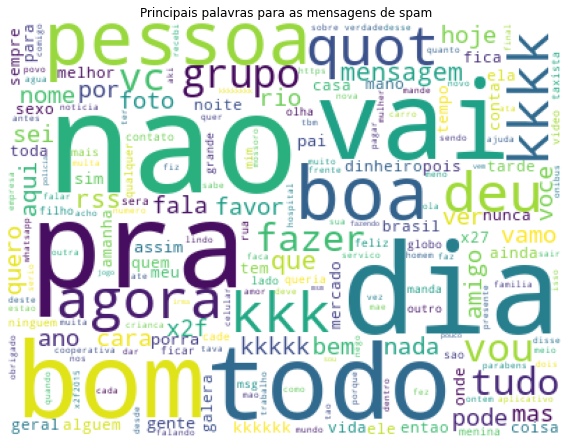

In [32]:
plt.figure(figsize=(10,8))
plt.imshow(wc_spam)
plt.title('Principais palavras para as mensagens de spam')
plt.axis('off')
plt.show()

Encontra as principais palavras para as mensagens de não-spamn

In [33]:
wc_nospam = WordCloud(collocations=False,
                    max_font_size=100,
                    width=400,
                    height=300,
                    background_color='white').generate(total_nospam_text)

Visualização das principais palavras das mensagens de não-spam

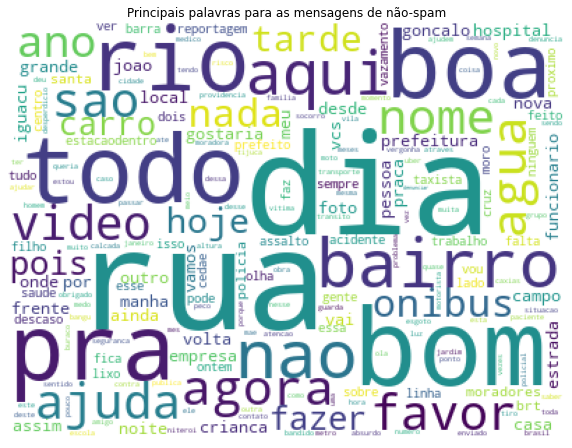

In [34]:
plt.figure(figsize=(10, 8))
plt.imshow(wc_nospam)
plt.title('Principais palavras para as mensagens de não-spam')
plt.axis('off')
plt.show()

### Vetorização

Transformando textos em matriz de com recursos tfidf

In [35]:
tfidf = TfidfVectorizer()
x_tfid = tfidf.fit_transform(train['Normalize_text'])
print(x_tfid)

  (0, 5837)	0.728089612576392
  (0, 5206)	0.6854819589590665
  (1, 2054)	0.5434552858785923
  (1, 5030)	0.5434552858785923
  (1, 1333)	0.5151609173156257
  (1, 3787)	0.3793704439881392
  (2, 5219)	0.5695461017194506
  (2, 6054)	0.3013672093128968
  (2, 7845)	0.40911845589265683
  (2, 8867)	0.3029745464021009
  (2, 2954)	0.41942032133746276
  (2, 3521)	0.3869239595796087
  (3, 4980)	0.31184442717902594
  (3, 6056)	0.44242747720633474
  (3, 5109)	0.5014231835801788
  (3, 5910)	0.2184850036058245
  (3, 4772)	0.3916623681615177
  (3, 5838)	0.3977989481645407
  (3, 4793)	0.3101719861999165
  (4, 8271)	0.7071067811865475
  (4, 9315)	0.7071067811865475
  (5, 427)	0.3054793831580636
  (5, 7066)	0.2902829010706667
  (5, 6600)	0.3522841548334805
  (5, 4024)	0.3522841548334805
  :	:
  (1772, 8733)	0.232654988013855
  (1772, 548)	0.232654988013855
  (1772, 3544)	0.22054207615168728
  (1772, 4275)	0.19983491655216648
  (1772, 4238)	0.20528161197393197
  (1772, 2067)	0.21194782841433424
  (1772, 401

### Classificação

Crianção da coluna Num-Spam com os valores 0 para False e 1 para True

In [36]:
train['SPAM_NUM'] = train['SPAM'].map({False: 0, True: 1})
train.head()

,Message,SPAM,Message_len,Normalize_text,SPAM_NUM
0,Linda msg!,True,10,linda msg,1
1,To fazendo batida de kwui com coco,True,34,fazendo batida kwui coco,1
2,Esse dinheiro só vai sair para quem está com o...,True,137,esse dinheiro vai sair nome lista esse dinheir...,1
3,Isso msm Irmã.. nao lembrava dos nomes kkk,True,42,isso msm irma nao lembrava nomes kkk,1
4,Ai xara eu sujiro esse,True,22,xara sujiro,1


Divisão para os conjuntos de treino e de validação

In [37]:
y=train['SPAM_NUM']
x_train, x_val, y_train,y_val = train_test_split(x_tfid, y, test_size=0.3, stratify=y, random_state=42)

### Tpot:
 Tpot é uma ferramenta de aprendizado de máquina automatizado Python que otimiza pipelines de aprendizado de máquina usando programação genética. Ele automatizará a parte mais custosa de encontrar o melhor modelo que no nosso caso é para a classificação de spam ou não-spam. Para mais detalhes: [Artigo](https://academic.oup.com/bioinformatics/article/36/1/250/5511404?login=false) ou [Tpot](http://epistasislab.github.io/tpot/citing/.)

### Escolha da métrica:
Para este problema escolhesmo a métrica  matthews_corrcoef do pacote sklearn. O coeficiente de correlação de Matthews é usado no aprendizado de máquina como uma medida da qualidade de classificações binárias e multiclasse. Ele leva em consideração verdadeiros e falsos positivos e negativos e é geralmente considerado como uma medida equilibrada que pode ser usada mesmo que as classes sejam de tamanhos muito diferentes. O MCC é essencialmente um valor de coeficiente de correlação entre -1 e +1. Um coeficiente de +1 representa uma previsão perfeita, 0 uma previsão aleatória média e -1 uma previsão imperfeita [MCC](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.matthews_corrcoef.html). Este método também é conhecido como coeficiente phi [Link](https://en.wikipedia.org/wiki/Phi_coefficient).

In [38]:
def scoring_mcc(y_true, y_pred):

    return matthews_corrcoef(y_true,y_pred)

In [39]:
my_custom_mcc = make_scorer(scoring_mcc, greater_is_better=True)

 O TPOTClassifier realiza uma pesquisa inteligente em pipelines de aprendizado de máquina que podem conter modelos de classificação supervisionados, pré-processadores, técnicas de seleção de recursos e qualquer outro estimador ou transformador que siga a API scikit-learn . O TPOTClassifier também pesquisará os hiperparâmetros de todos os objetos no pipeline [Link](https://epistasislab.github.io/tpot/api/).

In [40]:
%%time
model = TPOTClassifier(generations=5, population_size=20, cv=5, early_stop=1,
                       random_state=42, verbosity=2, config_dict='TPOT sparse', scoring=my_custom_mcc,
                       n_jobs=-2)

model.fit(x_train, y_train)

Optimization Progress:   0%|          | 0/120 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.7012169135073496

Generation 2 - Current best internal CV score: 0.7012169135073496

The optimized pipeline was not improved after evaluating 1 more generations. Will end the optimization process.

TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: MultinomialNB(CombineDFs(input_matrix, input_matrix), alpha=0.1, fit_prior=True)
CPU times: total: 37.1 s
Wall time: 8min 11s


TPOTClassifier(config_dict='TPOT sparse', early_stop=1, generations=5,
               n_jobs=-2, population_size=20, random_state=42,
               scoring=make_scorer(scoring_mcc), verbosity=2)

In [41]:
model.export('../Model/best_model1.py')

O melhor classificador encontrado

In [42]:
exported_pipeline = make_pipeline(
    make_union(
        FunctionTransformer(copy),
        FunctionTransformer(copy)
    ),
    MultinomialNB(alpha=0.1, fit_prior=True)
)
# Fix random state for all the steps in exported pipeline
set_param_recursive(exported_pipeline.steps, 'random_state', 42)
exported_pipeline.fit(x_train,y_train)

Pipeline(steps=[('featureunion',
                 FeatureUnion(transformer_list=[('functiontransformer-1',
                                                 FunctionTransformer(func=<function copy at 0x0000021EDCCC4F70>)),
                                                ('functiontransformer-2',
                                                 FunctionTransformer(func=<function copy at 0x0000021EDCCC4F70>))])),
                ('multinomialnb', MultinomialNB(alpha=0.1))])

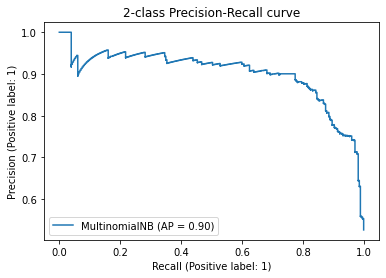

In [43]:
display = PrecisionRecallDisplay.from_estimator(
    exported_pipeline, x_val, y_val, name="MultinomialNB"
)
_ = display.ax_.set_title("2-class Precision-Recall curve")

#### Para encontrar o precision, recall e f1_score do dataset de teste fornecido é preciso a coluna de classificação para então encontrar os seus valores! Portanto, segue o resultado para o conjunto de validação dds dados de treino

In [44]:
y_hat = exported_pipeline.predict(x_val)

In [45]:
print('-----------------------------------------')
print(f'Precision:{precision_score(y_val, y_hat):.2%}')
print(f'Recall:{recall_score(y_val, y_hat):.2%}')
print(f'F1-Score:{f1_score(y_val, y_hat):.2%}')
print('----------------------------------------')

-----------------------------------------
Precision:87.64%
Recall:81.07%
F1-Score:84.23%
----------------------------------------
